The libraries used in this notebook are listed below.

In [1]:
import zipfile
import os
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from shutil import copyfile
from sklearn.model_selection import train_test_split

# importing library for ML processing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# CNN layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# Regularization
from tensorflow.keras import regularizers

# Saving the model
from tensorflow.keras.models import save_model

# Metrics for evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score

<h2>5.1.2 Data preparation for Machine Learning</h2>

Firstly, pre-porcessed training data is obtained and prepared for machine learning:


The labels for all the images is in the <code>image_enhanced_simple_data.csv</code> file. It is first extracted in the code below.

In [ ]:
csv_file = 'augmented_images.csv'

# Read the CSV file into a pandas DataFrame
df_classes = pd.read_csv(csv_file)
df_classes.info

Then the images are extracted from the <code>image_enhanced_PIL_simple.zip</code> file.

In [ ]:
# Paths
extracted_dir = 'augmented_images'

# Check the length of the extracted images
num_extracted_images = len(os.listdir(extracted_dir))
print(f"Number of extracted images: {num_extracted_images}")
print("Extraction completed.")

Number of extracted images: 26660
Extraction completed.


Both images and there labels extracted contains the same number of entries.

The distribution of the final classes is shown below.

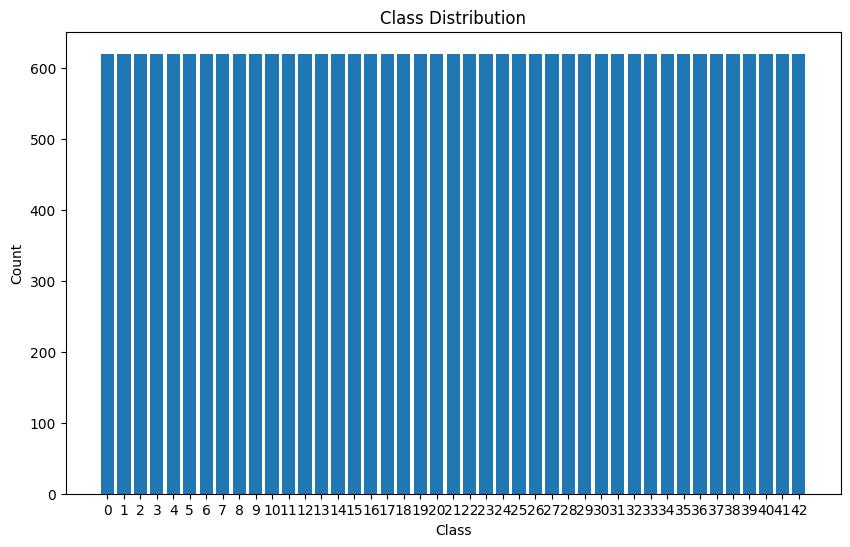

In [ ]:
# Count the occurrences of each class in the DataFrame
class_counts = df_classes['class'].value_counts()

# Sort the unique class IDs
unique_classes = np.sort(df_classes['class'].unique())

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(unique_classes, class_counts[unique_classes])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(unique_classes)
plt.show()

In [ ]:
extracted_dir ='augmented_images'

In [ ]:
train_dir = 'train_images'
valid_dir = 'valid_images'

# Create directories for training and validation images
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)

# Split the data into training and validation sets
train_df, valid_df = train_test_split(df_classes, test_size=0.2, random_state=42, stratify=df_classes['class'])

# Copy images to directories based on classes for training set
for index, row in train_df.iterrows():
    src_path = os.path.join(extracted_dir, row['filename'])
    dst_path = os.path.join(train_dir, str(row['class']), row['filename'])
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    copyfile(src_path, dst_path)

# Copy images to directories based on classes for validation set
for index, row in valid_df.iterrows():
    src_path = os.path.join(extracted_dir, row['filename'])
    dst_path = os.path.join(valid_dir, str(row['class']), row['filename'])
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    copyfile(src_path, dst_path)

print("Data preparation for ML completed.")

Data preparation for ML completed.


<h1> 5.2 Machine Learning</h1>

<h2>5.2.1 Data pipeline</h2>

<code>flow_from_directory()</code> from Keras ImageDataGenerator is used to load the images with rescaling to 1/255. batch size and image size are pre-set to 32 and (160, 160), respectively. These number were based on the upscaling of images in image enhancement.

In [2]:
# Define paths
train_dir = 'train_images'
valid_dir = 'valid_images'

# Define image dimensions and batch size
image_size = (160,160)
batch_size = 32

# Create data generators and rescale image for ML on training and validation
train_datagen = ImageDataGenerator(rescale=1.0/255)
valid_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Load images as grayscale
    shuffle=True  # Set shuffle to True for training data
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Load images as grayscale
    shuffle=False  # Set shuffle to False for validation data
)

# Get the number of classes from the training generator
num_classes = len(train_generator.class_indices)

Found 21328 images belonging to 43 classes.
Found 5332 images belonging to 43 classes.


Total <b>21328</b> images are loaded into the training data and <b>5332</b> images are loaded into the validation data.

Next, the test data is also obtained and prepared for machine learning.

In [3]:
test_extracted_dir ='augmented_images_test'
test_dir = 'test_images'

In [4]:
# Move the test images to the test directory while renaming them with their true labels
for filename in os.listdir(test_extracted_dir):
    src_path = os.path.join(test_extracted_dir, filename)
    true_label = filename.split('_')[0]
    dst_path = os.path.join(test_dir, true_label, filename)
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    copyfile(src_path, dst_path)

Data generator is used for loading images into the model.

In [5]:
# Create a data generator for the test data
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Load images as grayscale
    shuffle=False  # Set shuffle to False for testing data
)

Found 12599 images belonging to 43 classes.


<h2>5.2.2 Training the CNN model</h2>

As there are many models training at the same time, the first image in the training data is inspected on size to confirm the shape of the nerual network.

In [6]:
# Define the path to the image file
image_path = os.path.join('train_images', '0', '0_0.png')

# Open the image using PIL
image = Image.open(image_path)

# Get the size (dimensions) of the image
image_size = image.size

# Close the image file
image.close()

# Print the size of the image
print("Size of '0_0.png' in folder '0':", image_size)


Size of '0_0.png' in folder '0': (160, 160)


In [7]:
# Retrieve the first batch from the training generator
images, labels = next(train_generator)

# Get the first image from the batch
first_image = images[0]

# Check the shape of the first image
print("Shape of the first image:", first_image.shape)


Shape of the first image: (160, 160, 1)


The size of image accurate reflects the simple enhanced data with all three channels.

The GPU avaliability is also double checked.

In [8]:
# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Specify GPU device
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.95)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Num GPUs Available:  1


A function is defined to plot the training history and calculate the changes in accuracy and loss.

In [9]:
def calculate_accuracy_increase_rate(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    train_rate = np.mean(np.diff(train_accuracy))
    val_rate = np.mean(np.diff(val_accuracy))

    return train_rate, val_rate

In [10]:
def plot_training_history(history):
    # Access the training history
    training_loss = history.history['loss']
    training_accuracy = history.history['accuracy']
    validation_loss = history.history['val_loss']
    validation_accuracy = history.history['val_accuracy']

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plotting the training and validation accuracy
    ax1.plot(training_accuracy)
    ax1.plot(validation_accuracy)
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Plotting the training and validation loss
    ax2.plot(training_loss)
    ax2.plot(validation_loss)
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the figure
    plt.show()

Then, true labels are extracted from the test generator for testing later.

In [11]:
# Get true labels from the test generator
true_labels = test_generator.classes

# Get unique true labels
class_names = [str(label) for label in range(43)]

The model development will start from developing a simple model that serves as a baseline in this development cycle. It is different from the basline of the whole project as this is trained on enhanced and augmented data.

<h2> Model 4: Even more complex CNN with regularization and more layers</h2>


As the previous model not performing well, an attempt has been made to add more layers to the model so that it could potentially allow a **more complexed model** with less likelihood of overfitting, at a cost of **increased training time**.

In [12]:
# Define a more complex CNN architecture
input_layer = Input(shape=(160, 160, 1))
x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)

# Add another dense layer with dropout
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)

output_layer = Dense(num_classes, activation='softmax')(x)

# Create the model
model_modified = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with a lower learning rate
model_modified.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


The above model is revised from all previous models. It added more omore set of dense layers and dropout layers with regularization. It also had a lower learning rate.

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
num_epochs = 50
history_modified_model = model_modified.fit(train_generator,
                                            epochs=num_epochs,
                                            validation_data=valid_generator,
                                            callbacks=[early_stopping])

print("Model training completed.")

The training stopped at **epoch 26** as the model started overfitting (shown by the validation loss). This happend 12 epoch before the previous model. The training accuracy and validation accuracy graph are shown below. It was noted that the **training accuracy** and the **validation accuracy** are both **still very high**.

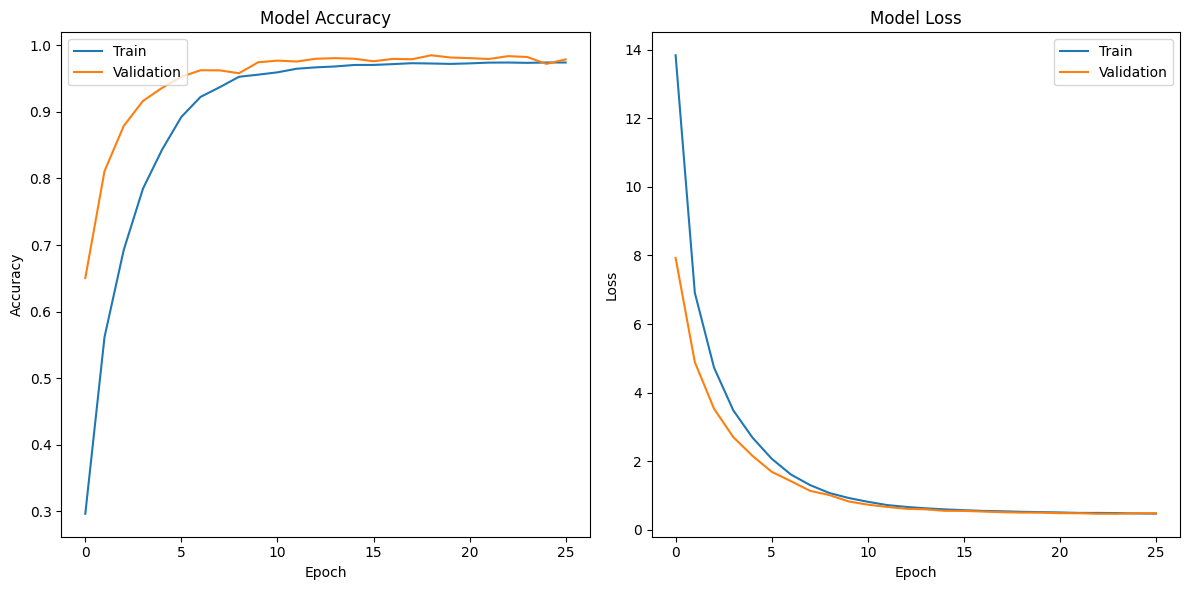

In [ ]:
plot_training_history(history_modified_model)

This model has a similar training accuracy than validation accuracy. UnLike the previous model, validation accuracy did **not experienced significant fluctuations**. The model is thus much more **stable**. Moreover, it is still no indications of overfitting.

In [ ]:
# Test the model with the test data
test_loss_mComplex, test_accuracy_mComplex = model_modified.evaluate(test_generator)

print(f"Test Loss: {test_loss_mComplex:.4f}")
print(f"Test Accuracy: {test_accuracy_mComplex:.4f}")

394/394 [==============================] - 27s 68ms/step - loss: 0.6445 - accuracy: 0.9296
Test Loss: 0.6445
Test Accuracy: 0.9296


In [ ]:
# Make predictions on the test data
test_pred_modified = model_modified.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_labels_modified = np.argmax(test_pred_modified, axis=1)

# Calculate the precision score
precision_modified = precision_score(true_labels, predicted_labels_modified, average='weighted')

print(f"Precision Score: {precision_modified:.4f}") # 85 87

394/394 [==============================] - 26s 65ms/step
Precision Score: 0.9337


After this adjustment, the new model did **not perform better** than the previous model. Thus, the exploration of model structure is concluded.

The project will more on to saving this model and training of other models.

 <h1> 5.3 Saving the model</h1>

The raw predictions, training history, and model are saved below. They were all saved to google drive for reusing and analysis in the future.



In [ ]:
# Define the file path where you want to save the raw predictions
save_path = "best_test_predictions_CNN.npy"

# Save the raw predictions to the specified file
np.save(save_path, test_pred_modified)

print(f"Raw predictions saved to '{save_path}'.")

Raw predictions saved to 'best_test_predictions_CNN.npy'.


In [ ]:
model_modified.save("final_CNN_model.keras")

In [ ]:
def save_training_history(history, filename):
    # Create a DataFrame from the training history
    history_df = pd.DataFrame(history.history)

    # Save the DataFrame to a CSV file
    history_df.to_csv(filename, index=False)

    # Print the first few rows of the history DataFrame
    print(history_df.head())

In [ ]:
save_training_history(history_simpleCNN, 'training_history_simpleCNN.csv')
save_training_history(history_modified_model, 'training_history_complexCNN.csv')

       loss  accuracy  val_loss  val_accuracy
0  1.793514  0.499156  0.590471      0.832333
1  0.698569  0.784649  0.328200      0.907914
2  0.468224  0.851604  0.297311      0.915979
3  0.345081  0.888878  0.226612      0.931920
4  0.275400  0.911619  0.232147      0.927794
        loss  accuracy  val_loss  val_accuracy
0  13.842560  0.296418  7.928982      0.650413
1   6.911101  0.561750  4.887598      0.810953
2   4.727787  0.692564  3.526845      0.878845
3   3.482876  0.784555  2.701056      0.916354
4   2.685626  0.843445  2.153270      0.936047


In [ ]:
import shutil
import os

# Define the destination directory in Google Drive
dest_dir = 'models'

# Create the destination directory if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)

# Define the source paths
src_paths = [
    'final_CNN_model.h5',
    'final_CNN_model.keras',
    'training_history_simpleCNN.csv',
    'training_history_complexCNN.csv',
    'best_test_predictions_CNN.npy'
]

# Copy files to Google Drive
for src_path in src_paths:
    shutil.copy(src_path, dest_dir)

print("Files copied to Google Drive successfully.")

Files copied to Google Drive successfully.
